In [1]:
# Module Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib.cm import ScalarMappable
import seaborn as sns
import scipy.spatial as sp
import scipy.stats as stats

In [40]:
# Constant Variables
NEXTSEQ_ENRICHMENT_PATH = "2023_09_08_Ru_enrich_fits.csv"

REFERENCE_DATA = 'in_vitro_data_summary.csv'

BOOTSTRAP_DATA = "2024_03_18_bootstrap_update_kH.csv"

STD_DATA = "std_data.csv"

MEAS2_DATA = "meas2_data.csv"

TRIMMED_ERROR = "2023_09_22_trimmed_error.csv"

OUTPUT_FIGURE_PATH = './'

AMINOACID_SEQ = 'MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFAAESSTGTNVEVCTTDDFTRGVDALVYEVDEARELTKIAYPVALFDRNITDGKAMIASFLTLTMGNNQGMGDVEYAKMHDFYVPEAYRALFDGPSVNISALWKVLGRPEVDGGLVVGTIIKPKLGLRPKPFAEACHAFWLGGDFIKNDEPQGNQPFAPLRDTIALVADAMRRAQDETGEAKLFSANITADDPFEIIARGEYVLETFGENASHVALLVDGYVAGAAAITTARRRFPDNFLHYHRAGHGAVTSPQSKRGYTAFVHCKMARLQGASGIHTGTMGFGKMEGESSDRAIAYMLTQDEAQGPFYRQSWGGMKACTPIISGGMNALRMPGFFENLGNANVILTAGGGAFGHIDGPVAGARSLRQAWQAWRDGVPVLDYAREHKELARAFESFPGDADQIYPGWRKALGVEDTRSALPA*'

# Use consistent aa order
INDEX_ORDER = ['P', 'W', 'F', 'Y', 'I', 'L', 'M', 'V', 'A', 'G',
               'S', 'T', 'C', 'N', 'Q', 'D', 'E', 'K', 'R', 'H']

# Experimental details
CONDITIONS_KEY = {
    'WT_only'                  : ['NP_11_64_2'],
    't0'                       : ['NP_11_64_9', 'NP_11_64_11', 'NP_11_64_12', 'NP_11_64_13', 'NP_11_64_15'],
    '0.04percent_CO2'          : ['NP_11_66_41'],
    '0.2percent_CO2'           : ['NP_11_66_1',  'NP_11_66_2',  'NP_11_66_3'],
    '0.3percent_CO2'           : ['NP_11_66_7',  'NP_11_66_8',  'NP_11_66_9'],
    '0.4percent_CO2'           : ['NP_11_66_4',  'NP_11_66_5',  'NP_11_66_6'],
    '1percent_CO2'             : ['NP_11_66_10', 'NP_11_66_11', 'NP_11_66_12'],
    '5percent_CO2_20uM_IPTG'   : ['NP_11_66_13', 'NP_11_66_14', 'NP_11_66_15',
                                  'NP_11_66_16', 'NP_11_66_17', 'NP_11_66_18',
                                  'NP_11_66_37', 'NP_11_66_38', 'NP_11_66_39'],
    '0uM_IPTG'                 : ['NP_11_66_19', 'NP_11_66_20', 'NP_11_66_21'],
    '5uM_IPTG'                 : ['NP_11_66_22', 'NP_11_66_23', 'NP_11_66_24'],
    '30uM_IPTG'                : ['NP_11_66_25', 'NP_11_66_26', 'NP_11_66_27'],
    '100uM_IPTG'               : ['NP_11_66_28', 'NP_11_66_29', 'NP_11_66_30'],
    '300uM_IPTG'               : ['NP_11_66_31', 'NP_11_66_32', 'NP_11_66_33'],
    '1000uM_IPTG'              : ['NP_11_66_34', 'NP_11_66_35', 'NP_11_66_36'],
    'Xylose'                   : ['NP_11_66_40']

}

TITRATION_DICT = {'CO2'  : ['0.04percent_CO2',
                           '0.2percent_CO2',
                           '0.3percent_CO2',
                           '0.4percent_CO2',
                           '1percent_CO2',
                           '5percent_CO2_20uM_IPTG'],
                 'IPTG' : ['0uM_IPTG',
                           '5uM_IPTG',
                           '5percent_CO2_20uM_IPTG',
                           '30uM_IPTG',
                           '100uM_IPTG',
                           '300uM_IPTG',
                           '1000uM_IPTG']
                }

CONCENTRATION_DICT = {'CO2'  : [0.04, 0.2, 0.3, 0.4, 1, 5],
                      'IPTG' : [0, 5, 20, 30, 100, 300, 1000]
                      }

KmWT = 0.149


In [29]:
# Functions

def corrfunc(x, y, **kws):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)  


def getCO2Conc(percentCO2, temp, kHCO2 = 0.034, VHCO2 = 2400):
    atmCO2 = percentCO2/100
    kTCO2 = kHCO2*(np.e**(VHCO2*((1/(temp+273.15))-(1/298.15))))
    CO2Conc = kTCO2 * atmCO2
    return CO2Conc


def logMichaelisEq(co2Conc, VmaxRatio, KmMut):
    return np.log10((VmaxRatio*(KmWT + co2Conc))/(KmMut + co2Conc))


def linMichaelisEq(co2Conc, VmaxRatio, KmMut):
    return (VmaxRatio*(KmWT + co2Conc))/(KmMut + co2Conc)


def mm_velocity(co2_conc0, VmaxRatio0, Km0):
    mm_vel0 = VmaxRatio0*co2_conc0 / (Km0 + co2_conc0)
    return mm_vel0


def Km_fit_transform(df0, mutants0, Vmax_name, Km_name):
    if len(mutants0) == 1:
        co2_df0 = df0.loc[[mutants0]]
    else:
        co2_df0 = df0.loc[mutants0]


    mean_col_names = TITRATION_DICT['CO2'][1:]
    std_col_names = [cn + "_std" for cn in mean_col_names]

    fig, axs = plt.subplots(1,2, figsize = (6,3))
    co2_conc_fit = np.linspace(0,1.5)
    co2_conc = CONCENTRATION_DICT['CO2'][1:]

    mean_enrich = co2_df0[mean_col_names].to_numpy()
    std_enrich = co2_df0[std_col_names].to_numpy()
    pd.DataFrame(mean_enrich).to_csv('lukeValsFig3.csv')
    pd.DataFrame(std_enrich).to_csv('lukeStdValsFig3.csv')

    def MM_transform(co2_conc0, enrich0):
        transform0 =  np.array(co2_conc0)*(enrich0) / (KmWT + np.array(co2_conc0))
        #transform0 = np.array(co2_conc0)*(10**(enrich0 - 1)) / (KmWT + np.array(co2_conc0))
        return transform0

    mean_transform = MM_transform(co2_conc, mean_enrich)
    upper_transform = MM_transform(co2_conc, mean_enrich + std_enrich) - mean_transform
    lower_transform = mean_transform - MM_transform(co2_conc, mean_enrich - std_enrich)


    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    colors = ['#a1d185', '#ee64a5']

    for rind, row in enumerate(co2_df0.iterrows()):
        print(row)
        # Plot fitness data
        axs[0].plot([0,np.max(co2_conc_fit)],[1,1], 'k--')
        axs[0].plot(co2_conc_fit,
                   linMichaelisEq(co2_conc_fit, row[1][Vmax_name],row[1][Km_name]), color=colors[rind])
        axs[0].scatter(co2_conc, mean_enrich[rind,:], marker='o', s=100, color=colors[rind],
                       edgecolors='black',
                       linewidth = 0,
                       zorder=5,  label=mutants0[rind])
        axs[0].errorbar(co2_conc, mean_enrich[rind,:],
                        yerr=std_enrich[rind,:], fmt='none', ecolor=colors[rind], capsize=4)
        axs[0].set_xlabel('conc. CO2 (mM)')
        axs[0].set_ylabel('Fitness')
        axs[0].set_xlim([0,1.55])
        axs[0].set_ylim([0,1.2])
        axs[0].set_yticks([0, 0.5, 1])
        axs[0].legend(frameon = False)
        
        # Plot michaelis converted data
        axs[1].plot(co2_conc_fit, mm_velocity(co2_conc_fit, 1, KmWT), 'k--')
        axs[1].plot(co2_conc_fit,
                 mm_velocity(co2_conc_fit, row[1][Vmax_name],row[1][Km_name]) / row[1][Vmax_name],
                    color=colors[rind])
        axs[1].scatter(co2_conc, mean_transform[rind,:] / row[1][Vmax_name],
                       marker='o', s=100, color=colors[rind], edgecolors='black',linewidth = 0, zorder=5)
        axs[1].errorbar(co2_conc, mean_transform[rind,:] / row[1][Vmax_name],
                        yerr=np.array([upper_transform[rind,:], lower_transform[rind,:]])/row[1][Vmax_name],
                        fmt='none', ecolor=colors[rind], capsize=4)
        axs[1].set_xlabel('conc. CO2 (mM)')
        axs[1].set_ylabel('fractional saturation')
        axs[1].set_yticks([0, 0.5, 1])
        axs[1].set_xlim([0,1.55])
        axs[1].set_ylim([0,1.2])

        plt.tight_layout()
    plt.savefig(OUTPUT_FIGURE_PATH + 'MichaelisEx.svg')

    plt.show()

    return fig


def makePivot(dataFrame, dataType):
    pivotAA_Pos = dataFrame.pivot_table(index = 'residue', columns = 'position', values = dataType)
    pivotAA_Pos = pivotAA_Pos.reindex(INDEX_ORDER[::-1])
    return pivotAA_Pos

In [3]:
# Create a custom colormap
color1 = '#FF0000'
color2 = '#FFFFFF'
color3 = '#0000FF'

nan_color = '#C0C0C0'  # Define the color for NaN values

# Set font and figure parameters
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["figure.figsize"] = (3, 3)

# Pandas column setting
pd.set_option('display.max_columns', None)


In [4]:
# Load NextSeq Enrichment data

nextseq_enrichmend_df = pd.read_csv(NEXTSEQ_ENRICHMENT_PATH)


8760


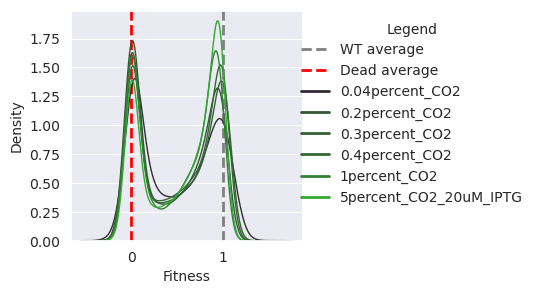

In [9]:
# Histogram by CO2

for condition in TITRATION_DICT['CO2']:
    nextseq_enrichmend_df[condition] = nextseq_enrichmend_df[CONDITIONS_KEY[condition]].mean(axis = 1)

histData = nextseq_enrichmend_df[['mutant'] + TITRATION_DICT['CO2']]

print(len(histData))

# Custom palette
custom_palette = {}

for i, condition in enumerate(TITRATION_DICT['CO2']):
    custom_palette[condition] = (0.2,(0.5 + np.log(CONCENTRATION_DICT['CO2'][i])/10),0.2)


# Plot vertical lines
plt.axvline(x=1, color='grey', linestyle='--', linewidth=2, label='WT average')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Dead average')

# Plot KDE plot
for i, condition in enumerate(TITRATION_DICT['CO2']):
    sns.kdeplot(data=histData[condition],
                fill=False,
                linewidth=1,
                alpha=1,
                color = custom_palette[condition]
               )

# Set labels and title
plt.xlabel('Fitness')
plt.ylabel('Density')

# Create custom legend handles and labels
legend_handles = [Line2D([0], [0], color='grey', linestyle='--', linewidth=2),
                  Line2D([0], [0], color='red', linestyle='--', linewidth=2)]

legend_labels = ['WT average', 'Dead average']

# Add KDE legend handles and labels
for label, color in custom_palette.items():
    legend_handles.append(Line2D([0], [0], color=color, linewidth=2))
    legend_labels.append(label)
    
# Make the plot frame thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
    
    
# Create legend for all elements
plt.legend(legend_handles, legend_labels, loc='upper right',
           bbox_to_anchor=(2, 1), title='Legend', frameon = False)

# Save and show the plot
plt.savefig(OUTPUT_FIGURE_PATH + 'CO2TitFitnessHist.svg', format='svg')
plt.show()


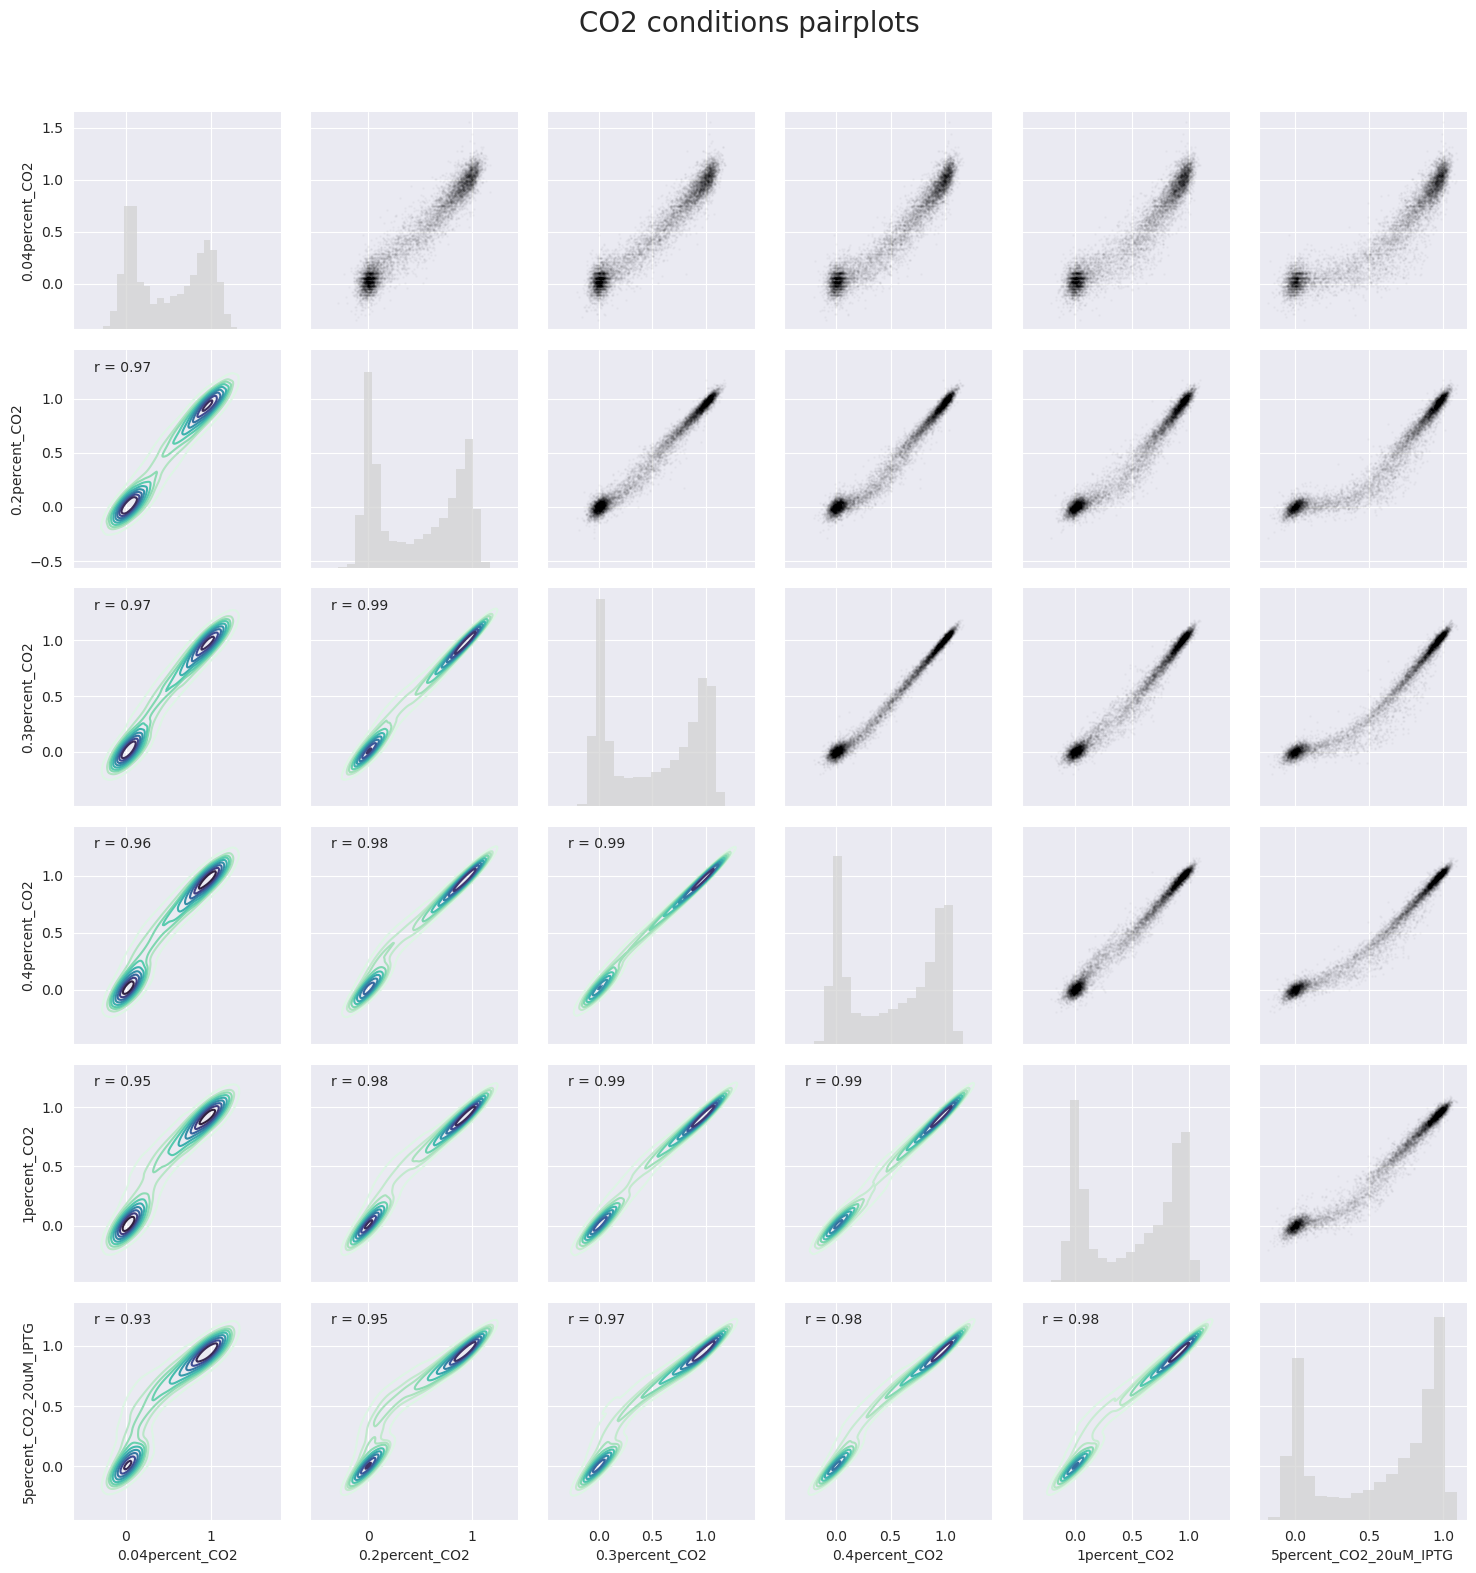

In [12]:
# Pairplots between conditions

pairplotData = nextseq_enrichmend_df[['0.04percent_CO2', '0.2percent_CO2', '0.3percent_CO2', 
                                  '0.4percent_CO2', '1percent_CO2', '5percent_CO2_20uM_IPTG']].dropna()

g = sns.PairGrid(pairplotData,
#                  hue = , palette=["red"]
                )
g.map_upper(plt.scatter, color = 'black',
            s=1,
            alpha = 0.02)
g.map_diag(sns.histplot,
           color = 'lightgrey',
           kde=False,
           edgecolor='none')
g.map_lower(corrfunc)
g.map_lower(sns.kdeplot,
            cmap="mako_r")
g.fig.suptitle("CO2 conditions pairplots", y=1.05, size = 20)
g.fig.savefig('CO2_conditions_pairplots.png')

In [5]:
# Calculate CO2 concentrations

CO2ConcList = []

for percentCO2 in [0.04,0.2,0.3,0.4,1,5]:
    CO2ConcList.append(getCO2Conc(percentCO2,37)*1000)
CO2ConcList

('V266T', 0.2percent_CO2                1.012088
0.3percent_CO2                1.019540
0.4percent_CO2                0.992889
1percent_CO2                  0.989885
5percent_CO2_20uM_IPTG        0.934177
0.2percent_CO2_std            0.065490
0.3percent_CO2_std            0.024365
0.4percent_CO2_std            0.024948
1percent_CO2_std              0.042795
5percent_CO2_20uM_IPTG_std    0.056921
Km_median                     0.132062
Km_qbcov                      0.133324
Vmax_median                   0.937873
Vmax_qbcov                    0.060212
Name: V266T, dtype: float64)
('V266G', 0.2percent_CO2                0.125756
0.3percent_CO2                0.209071
0.4percent_CO2                0.278599
1percent_CO2                  0.313024
5percent_CO2_20uM_IPTG        0.657606
0.2percent_CO2_std            0.228186
0.3percent_CO2_std            0.102865
0.4percent_CO2_std            0.100659
1percent_CO2_std              0.150626
5percent_CO2_20uM_IPTG_std    0.091177
Km_median      

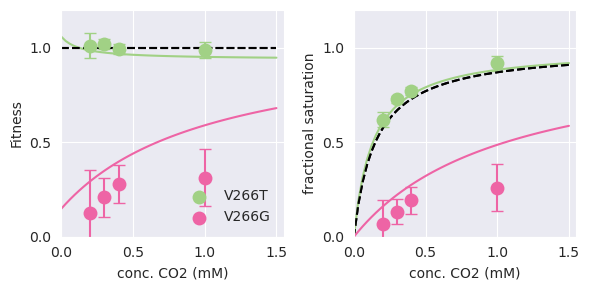

In [17]:
# Michaelis Menten curves - enrichment, converted, Oliver

co2_df = pd.read_csv('2024_02_23_boot_combo_for_MM.csv', index_col='mutant')
blob = Km_fit_transform(co2_df, ['V266T','V266G'], 'Vmax_median', 'Km_median')


WT
0.8045511947988473 0.9982917454661479
V266T
0.15319832511345852 0.8492920940110181


/tmp/ipykernel_3322698/738120013.py:82: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(co2_conc_fit,


V266G
3.5450231678698056 1.2237868993155763


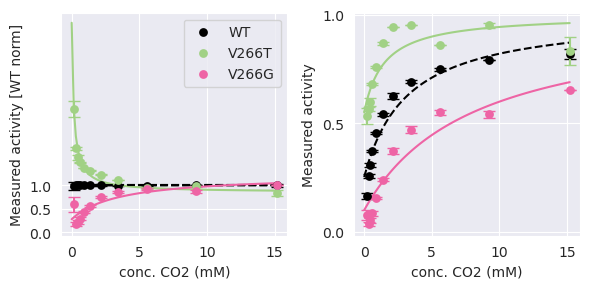

WT
0.8045511947988473 0.9982917454661479
V266T
0.15319832511345852 0.8492920940110181


/tmp/ipykernel_3322698/738120013.py:82: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(co2_conc_fit,


V266G
3.5450231678698056 1.2237868993155763
A102Y
0.32076849492368525 0.9631258958470567


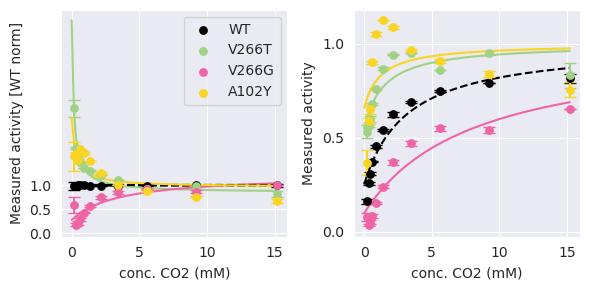

In [20]:
# Put in biochem data

std = pd.read_csv(STD_DATA, index_col='Unnamed: 0')
std = std[["WT1","V266T", "V266G", "A102Y"]].transpose()
std.columns = [str(i)+'_std' for i in range(11)]
df_ = pd.read_csv(MEAS2_DATA, index_col='Unnamed: 0')
updated_concentration_dict = {'CO2'  : [(i+1.5)/10 for i in df_.BiCarbTitrVals.to_list()]}
df1 = df_[["WT1","V266T", "V266G", "A102Y"]]
df1 = df1.transpose()
df_o =pd.concat((df1, std), axis=1, join="inner")
wt_norm = pd.Series([*list(df_[["WT1", "WT2"]].mean(axis=1)),*list(df_[["WT1", "WT2"]].mean(axis=1))])
norm_df = df_o/wt_norm.values
norm_df.rename(index={'WT1': 'WT'}, inplace=True)
# Generate plots for michaelis menten conversion example

# changes here compared to lukes are the TITRATION_DICT, the KmWT we are using, that we are calculating 
# Vmax on the fly here from the fits instead of having it in the df + the x/ylims are commented out and
# I made the dots smaller

TITRATION_DICT = {'CO2'  : [i for i in range(0,11,1)],
                 'IPTG' : ['0uM_IPTG',
                           '5uM_IPTG',
                           '5percent_CO2_20uM_IPTG',
                           '30uM_IPTG',
                           '100uM_IPTG',
                           '300uM_IPTG',
                           '1000uM_IPTG']
                }

KmWT = 0.8
# don't use anywhere!
#def logMichaelisEq(co2Conc, VmaxRatio, KmMut):
#    return np.log10((VmaxRatio*(KmWT + co2Conc))/(KmMut + co2Conc))

def linMichaelisEq(co2Conc, VmaxRatio, KmMut):
    return (VmaxRatio*(KmWT + co2Conc))/(KmMut + co2Conc)


def mm_velocity(co2_conc0, VmaxRatio0, Km0):
    mm_vel0 = VmaxRatio0*co2_conc0 / (Km0 + co2_conc0)
    return mm_vel0


def Km_fit_transform(df0, mutants0, Vmax_name, Km_name):
    if len(mutants0) == 1:
        co2_df0 = df0.loc[[mutants0]]
    else:
        co2_df0 = df0.loc[mutants0]
    
    mean_col_names = TITRATION_DICT['CO2']
    std_col_names = [str(cn) + "_std" for cn in mean_col_names]
    
    fig, axs = plt.subplots(1,2, figsize = (6,3))
    #co2_conc_fit = np.linspace(0,15)
    co2_conc = updated_concentration_dict['CO2']
    
    mean_enrich = co2_df0[mean_col_names].to_numpy()
    std_enrich = co2_df0[std_col_names].to_numpy()
    
    def MM_transform(co2_conc0, enrich0):
        transform0 =  np.array(co2_conc0)*(enrich0) / (KmWT + np.array(co2_conc0))
        #transform0 = np.array(co2_conc0)*(10**(enrich0 - 1)) / (KmWT + np.array(co2_conc0))
        return transform0
    
    mean_transform = MM_transform(co2_conc, mean_enrich)
    upper_transform = MM_transform(co2_conc, mean_enrich + std_enrich) - mean_transform
    lower_transform = mean_transform - MM_transform(co2_conc, mean_enrich - std_enrich)
    
    colors = ['', '#a1d185', '#ee64a5', '#f9d423']
    
    for rind, row in enumerate(co2_df0.iterrows()):
        print(row[0])
        params, covariance = curve_fit(linMichaelisEq, co2_conc, mean_enrich[rind,:])
        V_max = params[0]
        K_m = params[1]
        print(K_m, V_max)
        co2_conc_fit = np.linspace(-0.001, max(co2_conc), 100)
        if 'WT' in row[0]:
                axs[0].plot(co2_conc_fit, 
                   linMichaelisEq(co2_conc_fit, V_max, K_m),'k--', color='black')

                axs[0].scatter(co2_conc, mean_enrich[rind,:], marker='o', s=40, color='black',
                            edgecolors='black',
                            linewidth = 0,
                            zorder=5,  label=mutants0[rind])
                axs[0].errorbar(co2_conc, mean_enrich[rind,:],
                                yerr=std_enrich[rind,:], fmt='none', ecolor='black', capsize=4)
        else:
                axs[0].plot([0,np.max(co2_conc_fit)],[1,1], 'k--')
                
                axs[0].plot(co2_conc_fit, 
                        linMichaelisEq(co2_conc_fit, V_max, K_m), color=colors[rind])

                axs[0].scatter(co2_conc, mean_enrich[rind,:], marker='o', s=40, color=colors[rind],
                            edgecolors='black',
                            linewidth = 0,
                            zorder=5,  label=mutants0[rind])
                axs[0].errorbar(co2_conc, mean_enrich[rind,:],
                                yerr=std_enrich[rind,:], fmt='none', ecolor=colors[rind], capsize=4)
        
        axs[0].set_xlabel('conc. CO2 (mM)')
        axs[0].set_ylabel('Measured activity [WT norm]')
        #axs[0].set_xlim([0,15.5])
        #axs[0].set_ylim([0,1.2])
        axs[0].set_yticks([0, 0.5, 1])

        params, covariance = curve_fit(linMichaelisEq, co2_conc, mean_transform[rind,:])
        V_max = params[0]
        K_m = params[1]

        axs[0].legend()
        if 'WT' in row[0]:
            #axs[1].plot(co2_conc_fit, mm_velocity(co2_conc_fit, 1, KmWT), 'k--')
            axs[1].plot(co2_conc_fit, 
                 linMichaelisEq(co2_conc_fit, V_max, K_m)/V_max, 'k--')
            axs[1].scatter(co2_conc, mean_transform[rind,:] /V_max,
                      marker='o', linestyle='-', s=40, edgecolors='black',linewidth = 0,
                           zorder=5, color='black')
            axs[1].errorbar(co2_conc, mean_transform[rind,:] /V_max,
                        yerr=np.array([upper_transform[rind,:], lower_transform[rind,:]]) / V_max,
                        fmt='none', capsize=4, color='black')
            
        else:
            axs[1].plot(co2_conc_fit, 
                    linMichaelisEq(co2_conc_fit, V_max, K_m)/V_max, color=colors[rind])

            axs[1].scatter(co2_conc, mean_transform[rind,:] /V_max,
                        marker='o', linestyle='-', s=40, color=colors[rind],
                           edgecolors='black',linewidth = 0, zorder=5)
            #axs[1].plot(co2_conc, mean_transform[rind,:] / V_max,
            #   linestyle='-', color=colors[rind], zorder=4)
            axs[1].errorbar(co2_conc, mean_transform[rind,:] /V_max,
                            yerr=np.array([upper_transform[rind,:], lower_transform[rind,:]]) / V_max,
                            fmt='none', ecolor=colors[rind], capsize=4)

        axs[1].set_xlabel('conc. CO2 (mM)')
        axs[1].set_ylabel('Measured activity')
        axs[1].set_yticks([0, 0.5, 1])
        #axs[1].set_xlim([0,1.55])
        #axs[1].set_ylim([0,1.2])
        
        plt.tight_layout()
    plt.savefig(OUTPUT_FIGURE_PATH + 'MichaelisExBiochem.svg')

    plt.show()
    
    return fig

# Michaelis Menten curves - enrichment, converted, Oliver
# fractional saturation reverses compared to WT! while enrichments are just the values compared to WT

# first column needs to be WT
blob = Km_fit_transform(norm_df, ['WT', 'V266T','V266G'], 'vmax_med', 'km')
blob = Km_fit_transform(norm_df, ['WT','V266T','V266G', 'A102Y'], 'vmax_med', 'km')


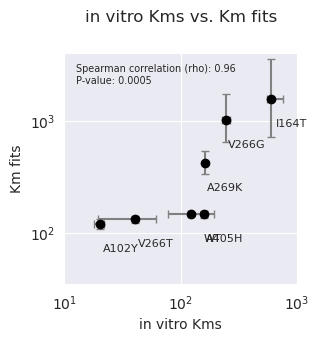

In [24]:
# Compare all in vitro data

# Enrichments vs. kcats from literature

refData = pd.read_csv(REFERENCE_DATA).dropna(subset = ['Savage Kc', 'Kc fit (median)'])
refData = refData[['Mutation', 'Savage Kc', 'Savage Kc error -', 'Vmax rel fit (median)',
         'Savage Kc error +', 'Kc fit (median)', 'KcFit 25th_perc', 'KcFit 75th_perc']]
refData['KcFit 75th_perc'] = refData['KcFit 75th_perc'].astype(float)

plt.errorbar(refData['Savage Kc'],
             refData['Kc fit (median)']*1000,
            xerr = (refData['Savage Kc error -'], refData['Savage Kc error +']),
            yerr = ((refData['Kc fit (median)'] - refData['KcFit 25th_perc'])*1000,
                    (refData['KcFit 75th_perc'] - refData['Kc fit (median)'])*1000),
            color = 'black',
             ecolor='gray',
             capsize=3,
            linestyle = None,
            fmt = 'o')

# Annotate each point with related text
for i in range(len(refData['Mutation'])):
    plt.annotate(refData.iloc[i]['Mutation'],  # Text to display
                 (refData.iloc[i]['Savage Kc'],
                  refData.iloc[i]['Kc fit (median)']*1000),  # Point to annotate
                 textcoords="offset points",  # How to position the text relative to the point
                 xytext=(15, -20),  # Offset from the point (in points)
                 ha='center',  # Horizontal alignment
                 fontsize=8)  # Font size of the text

# Calculate Spearman correlation
rho, p_value = stats.spearmanr(refData['Savage Kc'], refData['Kc fit (median)'])

# Annotate Spearman correlation
plt.annotate(f'Spearman correlation (rho): {rho:.2f}\nP-value: {p_value:.4f}',
             xy=(0.05, 0.88), xytext=(0, 10),
             xycoords=('axes fraction', 'figure fraction'),
             textcoords='offset points',
             ha='left', va='top',
             fontsize=7)

# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
plt.title('in vitro Kms vs. Km fits', y = 1.1)
plt.xlabel('in vitro Kms')
plt.ylabel('Km fits')
plt.ylim(35,4000)
plt.xlim(10,1000)
plt.xscale('log')
plt.yscale('log')

plt.savefig(OUTPUT_FIGURE_PATH + 'in vitro Km comparison.svg')
plt.show()

/tmp/ipykernel_3322698/3168334812.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(refData['Savage Kc'],


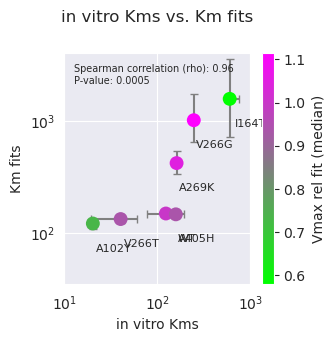

In [26]:
# Color by some value

# Sample data

color1 = '#00FF00'
color3 = '#FF00FF'

cmap = colors.LinearSegmentedColormap.from_list('custom_colormap', [color1, color3], N=1024)

# Convert the Vmax rel fit (median) values to colors using the colormap
norm = colors.Normalize(refData['Vmax rel fit (median)'].min(), refData['Vmax rel fit (median)'].max())
colors = cmap(norm(refData['Vmax rel fit (median)']))

fig, ax = plt.subplots()

# Create a ScalarMappable to map the colors to values
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty array for mapping

# Plot the scatter plot with colormap and error bars
scatter = ax.scatter(refData['Savage Kc'],
                     refData['Kc fit (median)'] * 1000,
                     c=colors,
                     edgecolors='k',  # Add black edges for better visibility
                     cmap=cmap,
                     s=100,  # Adjust marker size as needed
                     label='Data',
                    linewidth = 0,
           zorder = 10)

# Add error bars
ax.errorbar(refData['Savage Kc'],
            refData['Kc fit (median)'] * 1000,
            xerr=(refData['Savage Kc error -'], refData['Savage Kc error +']),
            yerr = ((refData['Kc fit (median)'] - refData['KcFit 25th_perc'])*1000,
                    (refData['KcFit 75th_perc'] - refData['Kc fit (median)'])*1000),
            fmt='none',
            ecolor='gray',
            capsize=3,
           zorder = 1)

# Create colorbar
cbar = plt.colorbar(sm, ax=ax, label='Vmax rel fit (median)')

# Annotate each point with related text
for i in range(len(refData['Mutation'])):
    plt.annotate(refData.iloc[i]['Mutation'],
                 (refData.iloc[i]['Savage Kc'], refData.iloc[i]['Kc fit (median)'] * 1000),
                 textcoords="offset points",
                 xytext=(15, -20),
                 ha='center',
                 fontsize=8)

# Calculate Spearman correlation
rho, p_value = stats.spearmanr(refData['Savage Kc'], refData['Kc fit (median)'])

# Annotate Spearman correlation
plt.annotate(f'Spearman correlation (rho): {rho:.2f}\nP-value: {p_value:.4f}',
             xy=(0.05, 0.88), xytext=(0, 10),
             xycoords=('axes fraction', 'figure fraction'),
             textcoords='offset points',
             ha='left', va='top',
             fontsize=7)

plt.title('in vitro Kms vs. Km fits', y=1.1)
plt.xlabel('in vitro Kms')
plt.ylabel('Km fits')
plt.ylim(35, 4000)
plt.xlim(10, 1000)
plt.xscale('log')
plt.yscale('log')
# plt.legend()

plt.show()


In [30]:
# Make Vmax and Km heatmaps

# Isolate relevant heatmap data
KmVmaxData = pd.read_csv(BOOTSTRAP_DATA)
nextseq_enrichmend_df = nextseq_enrichmend_df.merge(KmVmaxData, how = 'outer', on = 'mutant')
nextseq_enrichmend_df = nextseq_enrichmend_df.dropna(subset = ['position']).astype({'position':'int'})
heatMapData = nextseq_enrichmend_df[['mutant', 'position', 'WTresidue', 'residue',
                     '5percent_CO2_20uM_IPTG', 'Km_median', 'Km_qbcov', 'Vmax_median', 'Vmax_qbcov']]

# Fill in WT values
for position in np.arange(3,465):
    WTresVal = AMINOACID_SEQ[position - 1]
    mutVal = WTresVal + str(position) + WTresVal
    rowContents = [mutVal, int(position), WTresVal, WTresVal]
    rowContents.append(1)
    rowContents.append(0.149)
    rowContents.append(0)
    rowContents.append(1)
    rowContents.append(0)
    WTtempDF = pd.DataFrame([rowContents], columns=heatMapData.keys())
    heatMapData = pd.concat([WTtempDF, heatMapData])

pivotEnrichment = makePivot(heatMapData, '5percent_CO2_20uM_IPTG')
# Remove highly uncertain data, anything with qbcov > 1
pivotVmax = makePivot(heatMapData[heatMapData['Vmax_qbcov'] < 1],
                      'Vmax_median')
# Do Km in log scale and remove highly uncertain data, anything with qbcov > 1
KmHeatmapData = heatMapData[heatMapData['Km_qbcov'] < 1]
KmHeatmapData['KmLog'] = KmHeatmapData['Km_median'].apply(lambda x: np.log10(x))
pivotKm = makePivot(KmHeatmapData, 'KmLog')

enrichMin = heatMapData['5percent_CO2_20uM_IPTG'].min()
enrichMax = heatMapData['5percent_CO2_20uM_IPTG'].max()
VmaxMin = heatMapData[heatMapData['Vmax_qbcov'] < 1]['Vmax_median'].min()
VmaxMax = heatMapData[heatMapData['Vmax_qbcov'] < 1]['Vmax_median'].max()
KmMin = KmHeatmapData['KmLog'].min()
KmMax = KmHeatmapData['KmLog'].max()

#pivotKm

/tmp/ipykernel_3322698/3850127422.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KmHeatmapData['KmLog'] = KmHeatmapData['Km_median'].apply(lambda x: np.log10(x))


In [31]:
nextseq_enrichmend_df

,mutant,position,WTresidue,residue,NP_11_66_1,NP_11_66_2,NP_11_66_3,NP_11_66_4,NP_11_66_5,NP_11_66_6,NP_11_66_7,NP_11_66_8,NP_11_66_9,NP_11_66_10,NP_11_66_11,NP_11_66_12,NP_11_66_13,NP_11_66_14,NP_11_66_15,NP_11_66_16,NP_11_66_17,NP_11_66_18,NP_11_66_19,NP_11_66_20,NP_11_66_21,NP_11_66_22,NP_11_66_23,NP_11_66_24,NP_11_66_25,NP_11_66_26,NP_11_66_27,NP_11_66_28,NP_11_66_29,NP_11_66_30,NP_11_66_31,NP_11_66_32,NP_11_66_33,NP_11_66_34,NP_11_66_35,NP_11_66_36,NP_11_66_37,NP_11_66_38,NP_11_66_39,NP_11_66_40,NP_11_66_41,KmCO2_logfit,VmaxRatio_logfit,moment,0.04percent_CO2,0.2percent_CO2,0.3percent_CO2,0.4percent_CO2,1percent_CO2,5percent_CO2_20uM_IPTG,Km_mean,Km_std,Km_median,Km_qbcov,Vmax_mean,Vmax_std,Vmax_median,Vmax_qbcov,NaN_fraction,PearsonCorr,Vmax_25p,Vmax_75p,Km_25p,Km_75p
0,Q3Y,3,Q,Y,0.061435,-0.002794,-0.064470,0.223302,0.086143,0.054593,0.086776,0.097160,0.015438,0.175014,0.079249,-0.125079,0.395171,0.348857,0.465805,0.435418,0.452909,0.367713,0.308497,0.238125,0.339494,0.367540,0.289314,0.396301,0.553111,0.473676,0.488176,0.637437,0.393360,0.534265,0.556346,0.479150,0.416199,0.584102,0.592640,0.525011,0.374226,0.291064,0.445465,0.026095,-0.022029,0.516960,0.274647,0.559825,-0.022029,-0.001943,0.066458,0.121346,0.043061,0.397403,2.853730,3.424858,1.670726,1.310559,1.455943,1.210251,1.052160,0.804824,0.622314,0.929475,0.779938,1.626740,0.932459,3.122044
1,Q3C,3,Q,C,0.653414,0.559568,0.590622,0.611095,0.595902,0.654018,0.531020,0.626783,0.648802,0.655079,0.668640,0.566499,0.750400,0.744063,0.801224,0.677174,0.774846,0.811750,0.709773,0.654437,0.761401,0.727635,0.698470,0.805666,0.755172,0.805459,0.856183,0.755589,0.796200,0.792324,0.726002,0.742630,0.799533,0.775380,0.823459,0.794241,0.759310,0.799062,0.761612,0.125960,0.516988,0.262827,0.590623,0.148014,0.516988,0.601201,0.602202,0.620338,0.630072,0.764382,0.208116,0.034474,0.201704,0.215790,0.836476,0.059557,0.838695,0.094127,0.090909,0.347112,0.799443,0.878387,0.183720,0.227245
2,Q3D,3,Q,D,0.000000,0.124952,0.216148,0.278499,0.333185,0.260972,0.160405,0.241418,0.176835,0.230703,0.256414,0.113091,0.354563,0.428215,0.501219,0.390871,0.477526,0.523304,0.357621,0.307541,0.421614,0.319408,0.434280,0.508996,0.490901,0.523154,0.522318,0.735808,0.680499,0.687373,0.834669,0.814322,0.834950,0.795894,0.811288,0.875287,0.475425,0.406431,0.507886,-0.027625,0.110300,0.390742,0.303597,1.136410,0.110300,0.113700,0.192886,0.290885,0.200070,0.451716,0.670093,0.890761,0.496659,0.755884,0.791681,0.402757,0.745961,0.304733,0.042975,0.917817,0.638482,0.865801,0.360656,0.736073
3,Q3E,3,Q,E,0.036287,0.087762,0.104458,0.223302,0.210432,0.258519,0.107999,0.087094,0.176835,0.216647,0.177216,0.090675,0.361705,0.427675,0.447492,0.436022,0.428943,0.492553,0.335214,0.287967,0.452137,0.331336,0.293267,0.467137,0.437741,0.442659,0.566881,0.634876,0.592564,0.752799,0.915371,0.892766,0.982752,0.916043,0.836941,0.942314,0.325325,0.383587,0.460320,0.041011,0.076551,0.423593,0.286656,1.374643,0.076551,0.076169,0.123976,0.230751,0.161513,0.418180,0.876857,1.340311,0.589618,1.060377,0.819082,0.634259,0.709653,0.493818,0.238843,0.947389,0.557007,0.907446,0.332817,0.958033
4,Q3F,3,Q,F,0.198206,0.498158,0.430593,0.518319,0.462620,0.458327,0.398020,0.460847,0.413635,0.573780,0.581598,0.605329,0.654394,0.658501,0.761214,0.741355,0.702382,0.691229,0.641906,0.607472,0.669747,0.620388,0.608229,0.658441,0.776669,0.674039,0.707680,0.572240,0.526609,0.635960,0.478355,0.488924,0.392337,0.279537,0.381381,0.346475,0.701457,0.688443,0.685078,0.088959,0.467000,0.446001,0.606724,-0.638012,0.467000,0.375652,0.424167,0.479756,0.586902,0.698228,0.290942,0.080319,0.281099,0.375787,0.826518,0.104853,0.823840,0.133605,0.247934,0.561064,0.770252,0.880321,0.232928,0.338561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

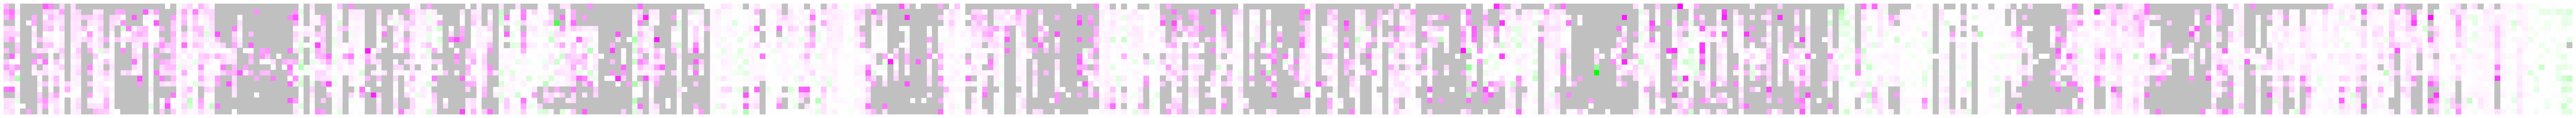

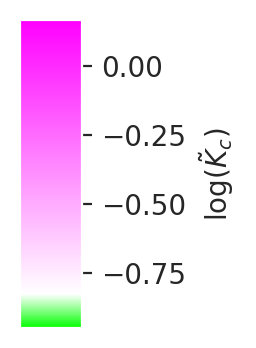

In [32]:
# Create the Km heatmap

# Create a custom colormap
totalRange = KmMax - KmMin
rangeUpTo1 = np.log10(0.149) - KmMin
Scaled1 = rangeUpTo1/totalRange
color1 = '#00FF00'
# color1 = [0,0.5,0,0.5]
color2 = '#FFFFFF'
# color2 = [0,0,0,0]
color3 = '#FF00FF'
# color3 = [0,1,0,0]

nan_color = '#C0C0C0'  # Define the color for NaN values
# nan_color = [0,0,0,0.25]  # Define the color for NaN values


fig, ax1 = plt.subplots(1, figsize=(92, 4), dpi=400)
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [(0, color1),
                                                                     (Scaled1, color2), (1, color3)], N=1024)

# Mask NaN values and assign them the 'nan_color'
pivotBCs_masked = np.ma.masked_invalid(pivotKm)

# Set the aspect ratio to 'auto' to prevent cutting off the edges
ax1.set_aspect('auto')

# Draw rectangles around NaN values (grey boxes)
for i in range(pivotBCs_masked.shape[0]):
    for j in range(pivotBCs_masked.shape[1]):
        if pivotBCs_masked.mask[i, j]:
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color=nan_color)
            ax1.add_patch(rect)

# Display the heatmap with the adjusted colormap
im = ax1.imshow(pivotBCs_masked, cmap=cmap)#, vmin=0, vmax=1)

# Invert the y-axis, not sure why this is necessary but it is
ax1.invert_yaxis()

# Remove the axis
ax1.axis('off')

# Save the heatmap without ticks or labels
plt.savefig(OUTPUT_FIGURE_PATH + 'KmHeatmap021424.png', format='png', bbox_inches='tight', pad_inches=0)

# Create a separate figure for the colorbar
fig_colorbar, ax_colorbar = plt.subplots(figsize=(0.4, 2), dpi=200)

# Add the colorbar to the colorbar figure
cbar = plt.colorbar(im, cax=ax_colorbar, label="log($\\tilde{K}_{c}$)")

# Save the colorbar figure
plt.savefig(OUTPUT_FIGURE_PATH + 'KmColorbar040524.svg', format='svg', bbox_inches='tight', pad_inches=0)

plt.show()

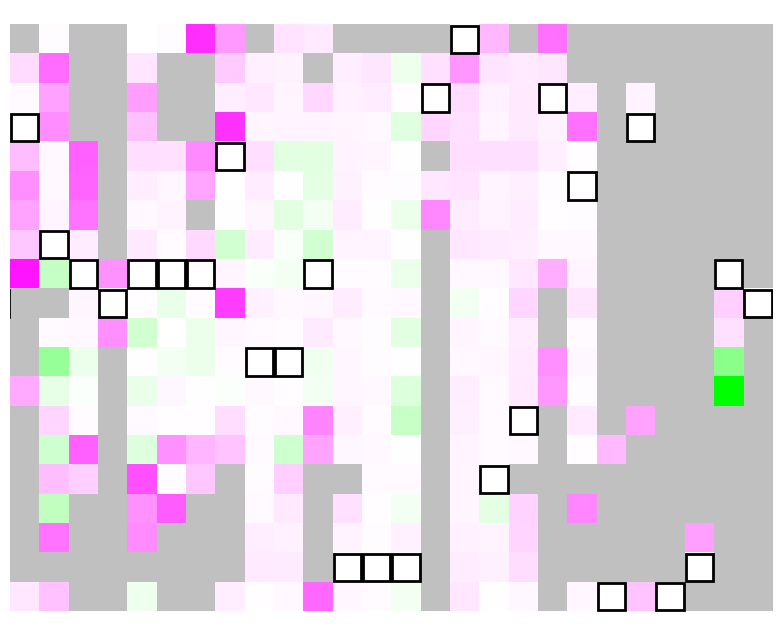

In [33]:
# Km heatmap inset
fig, ax1 = plt.subplots(1, figsize=(16, 8), dpi=100)

# Mask NaN values and assign them the 'nan_color'
pivotBCs_masked = np.ma.masked_invalid(pivotKm)
cmap.set_bad(nan_color)

# Draw rectangles around WT values
for i in np.arange(3,465):
    for j, AA in enumerate(INDEX_ORDER[::-1]):
        if AA == AMINOACID_SEQ[i+2]:
            rect = plt.Rectangle((i - 0.47, j - 0.47), 0.94, 0.94, fill=False, edgecolor='black', lw = 2)
            ax1.add_patch(rect)

ax1.imshow(pivotBCs_masked, cmap=cmap)
ax1.set_xlim(261.5, 287.503)
ax1.set_ylim(-1, 20)
ax1.axis('off')  # Turn off axis

# Save the heatmap without ticks or labels
plt.savefig(OUTPUT_FIGURE_PATH + 'KmHeatmapInset_040524.png', format='png', bbox_inches='tight', pad_inches=0)

plt.show()

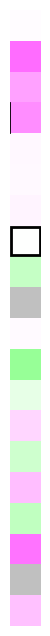

In [34]:
# Just position 266
# Km heatmap inset
fig, ax1 = plt.subplots(1, figsize=(16, 8), dpi=100)

# Draw rectangles around WT values
for i in np.arange(3,465):
    for j, AA in enumerate(INDEX_ORDER[::-1]):
        if AA == AMINOACID_SEQ[i+2]:
            rect = plt.Rectangle((i - 0.47, j - 0.47), 0.94, 0.94, fill=False, edgecolor='black', lw = 2)
            ax1.add_patch(rect)

ax1.imshow(pivotBCs_masked, cmap=cmap)
ax1.set_xlim(262.5, 263.503)
ax1.set_ylim(-0.5, 19.5)
ax1.axis('off')  # Turn off axis

# Save the heatmap without ticks or labels
plt.savefig(OUTPUT_FIGURE_PATH + 'KmHeatmapInset266_040524.png', format='png', bbox_inches='tight', pad_inches=0)

plt.show()

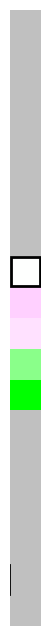

In [35]:
# Just position 289
# Km heatmap inset
fig, ax1 = plt.subplots(1, figsize=(16, 8), dpi=100)

# Draw rectangles around WT values
for i in np.arange(3,465):
    for j, AA in enumerate(INDEX_ORDER[::-1]):
        if AA == AMINOACID_SEQ[i+2]:
            rect = plt.Rectangle((i - 0.47, j - 0.47), 0.94, 0.94, fill=False, edgecolor='black', lw = 2)
            ax1.add_patch(rect)

ax1.imshow(pivotBCs_masked, cmap=cmap)
ax1.set_xlim(285.5, 286.503)
ax1.set_ylim(-0.5, 19.5)
ax1.axis('off')  # Turn off axis

# Save the heatmap without ticks or labels
plt.savefig(OUTPUT_FIGURE_PATH + 'KmHeatmapInset289_040524.png', format='png', bbox_inches='tight', pad_inches=0)

plt.show()

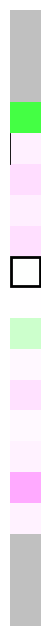

In [36]:
# Just position 102
# Km heatmap inset
fig, ax1 = plt.subplots(1, figsize=(16, 8), dpi=100)

# Draw rectangles around WT values
for i in np.arange(3,465):
    for j, AA in enumerate(INDEX_ORDER[::-1]):
        if AA == AMINOACID_SEQ[i+2]:
            rect = plt.Rectangle((i - 0.47, j - 0.47), 0.94, 0.94, fill=False, edgecolor='black', lw = 2)
            ax1.add_patch(rect)

ax1.imshow(pivotBCs_masked, cmap=cmap)
ax1.set_xlim(98.5, 99.503)
ax1.set_ylim(-0.5, 19.5)
ax1.axis('off')  # Turn off axis

# Save the heatmap without ticks or labels
plt.savefig(OUTPUT_FIGURE_PATH + 'KmHeatmapInset102_040524.png', format='png', bbox_inches='tight', pad_inches=0)

plt.show()

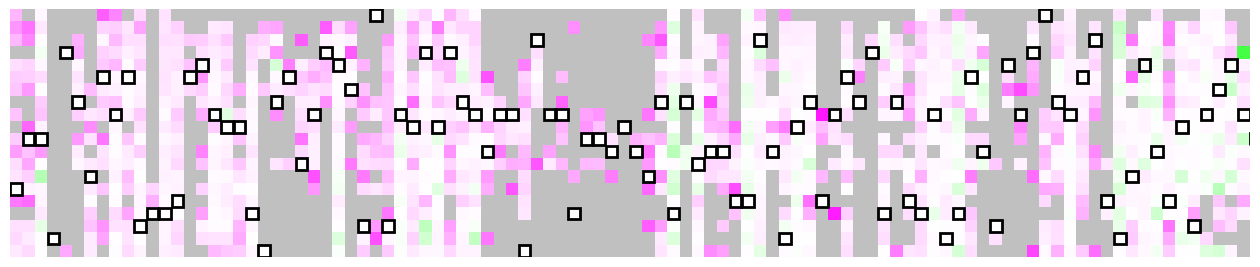

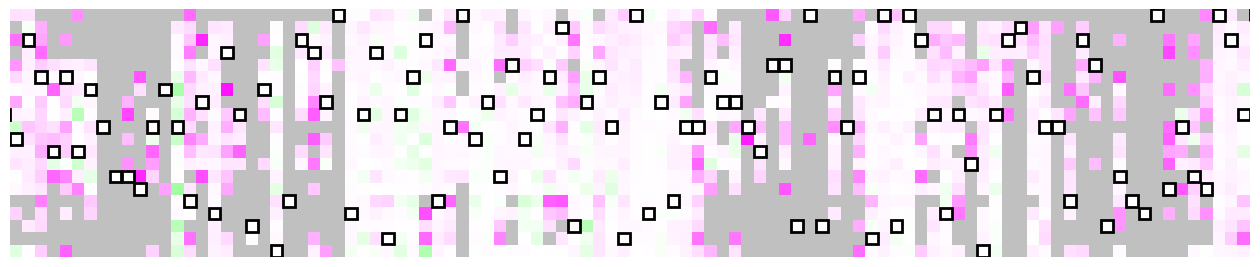

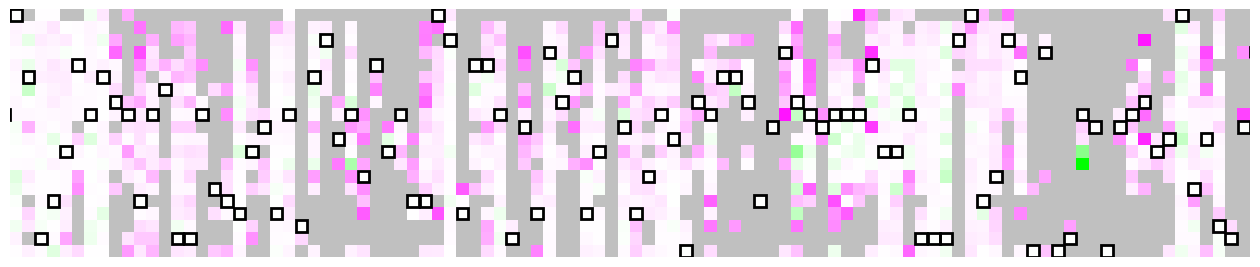

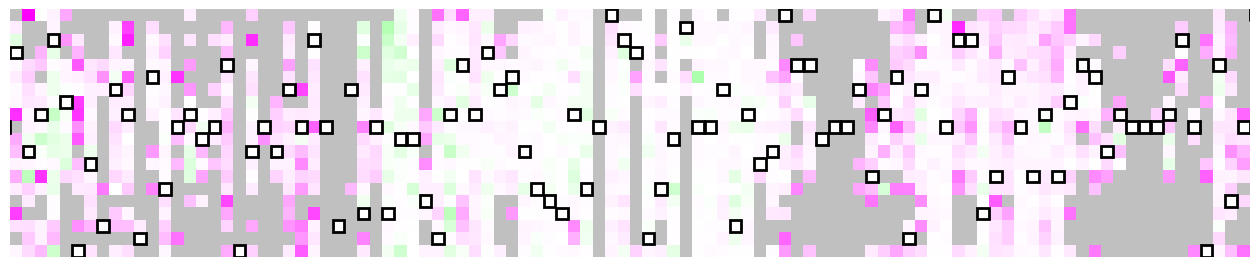

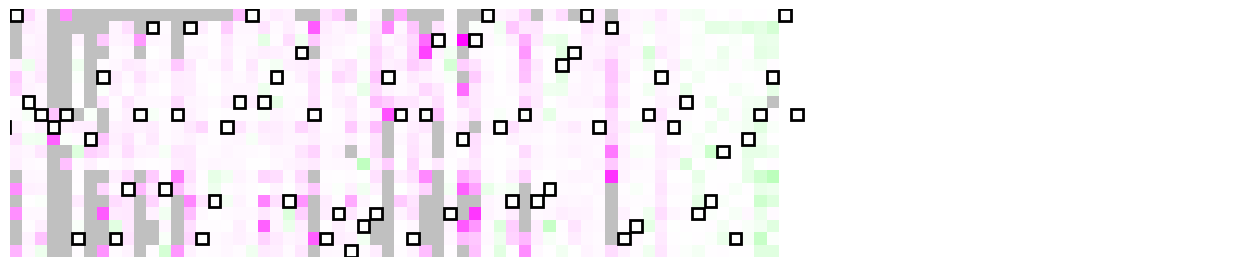

In [37]:
# Create supp file of heatmap at each position:

for k in [0,1,2,3,4]:
    fig, ax1 = plt.subplots(1, figsize=(16, 8), dpi=100)

    # Mask NaN values and assign them the 'nan_color'
    pivotBCs_masked = np.ma.masked_invalid(pivotKm)
    cmap.set_bad(nan_color)

    # Draw rectangles around WT values
    for i in np.arange(0,465):
        for j, AA in enumerate(INDEX_ORDER[::-1]):
            if AA == AMINOACID_SEQ[i+2]:
                rect = plt.Rectangle((i - 0.47, j - 0.47), 0.94,
                                     0.94, fill=False, edgecolor='black', lw = 2)
                ax1.add_patch(rect)

    ax1.imshow(pivotBCs_masked, cmap=cmap)
    ax1.set_xlim((100*k - 0.5), (100*(k+1) - 0.49))
    ax1.set_ylim(-0.5, 19.5)
    ax1.axis('off')  # Turn off axis

    # Save the heatmap without ticks or labels
    plt.savefig(OUTPUT_FIGURE_PATH + 'Supp_Km_heatmap_040524_part' + str(k) + '_.png',
                format='png', bbox_inches='tight', pad_inches=0)

    plt.show()

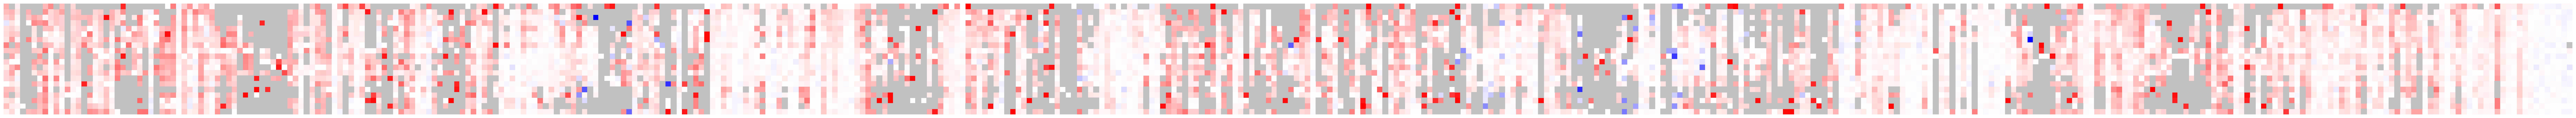

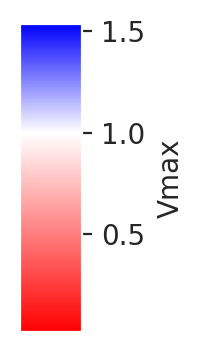

In [38]:
# Create the Vmax heatmap

# Create a custom colormap
totalRange = VmaxMax - VmaxMin
rangeUpTo1 = 1 - VmaxMin
Scaled1 = rangeUpTo1/totalRange
# Scaled1 = 0.5
color1 = '#FF0000'
color2 = '#FFFFFF'
color3 = '#0000FF'

nan_color = '#C0C0C0'  # Define the color for NaN values

fig, ax1 = plt.subplots(1, figsize=(92, 4), dpi=400)
cmapVmax = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [(0, color1),
                                                                     (Scaled1, color2), (1, color3)], N=1024)

# Mask NaN values and assign them the 'nan_color'
pivotBCs_masked = np.ma.masked_invalid(pivotVmax)

# Set the aspect ratio to 'auto' to prevent cutting off the edges
ax1.set_aspect('auto')

# Draw rectangles around NaN values (grey boxes)
for i in range(pivotBCs_masked.shape[0]):
    for j in range(pivotBCs_masked.shape[1]):
        if pivotBCs_masked.mask[i, j]:
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color=nan_color)
            ax1.add_patch(rect)

# Display the heatmap with the adjusted colormap
im = ax1.imshow(pivotBCs_masked, cmap=cmapVmax)#, vmin=0, vmax=1)

# Invert the y-axis, not sure why this is necessary but it is
ax1.invert_yaxis()

# Remove the axis
ax1.axis('off')

# Save the heatmap without ticks or labels
plt.savefig(OUTPUT_FIGURE_PATH + 'VmaxHeatmap040524.png', format='png', bbox_inches='tight', pad_inches=0)

# Create a separate figure for the colorbar
fig_colorbar, ax_colorbar = plt.subplots(figsize=(0.4, 2), dpi=200)

# Add the colorbar to the colorbar figure
cbar = plt.colorbar(im, cax=ax_colorbar, label="Vmax")

# Save the colorbar figure
plt.savefig(OUTPUT_FIGURE_PATH + 'VmaxColorbar040524.svg', format='svg', bbox_inches='tight', pad_inches=0)

plt.show()

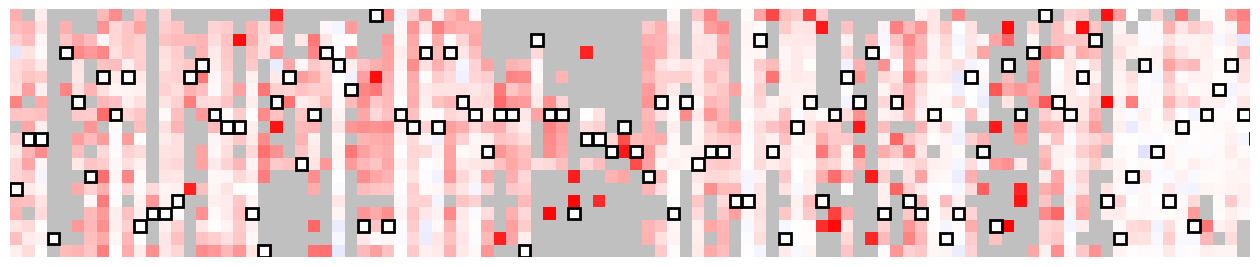

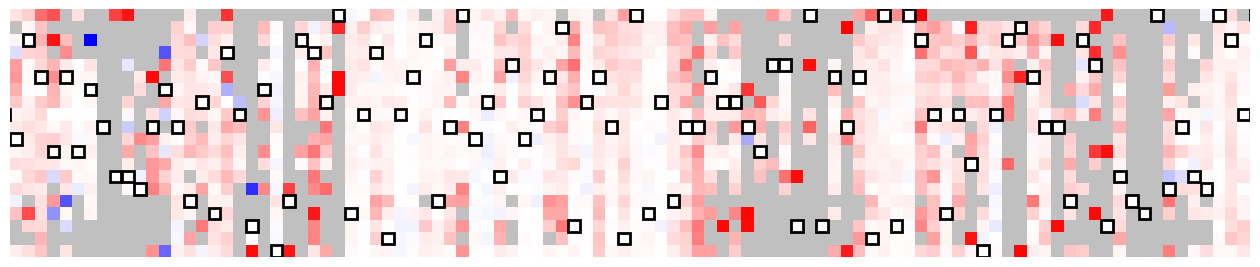

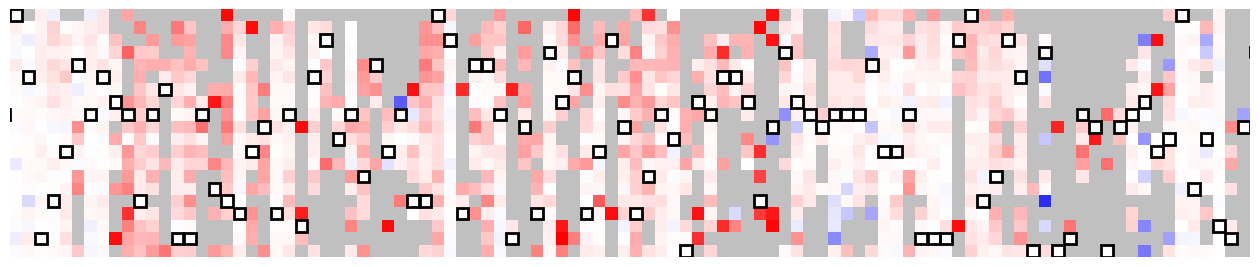

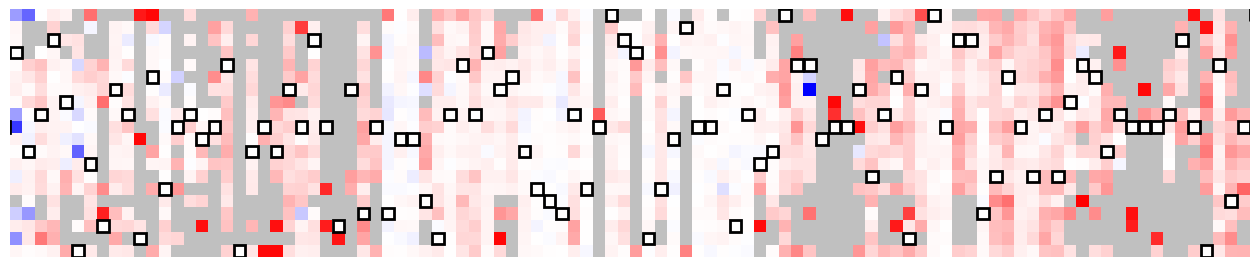

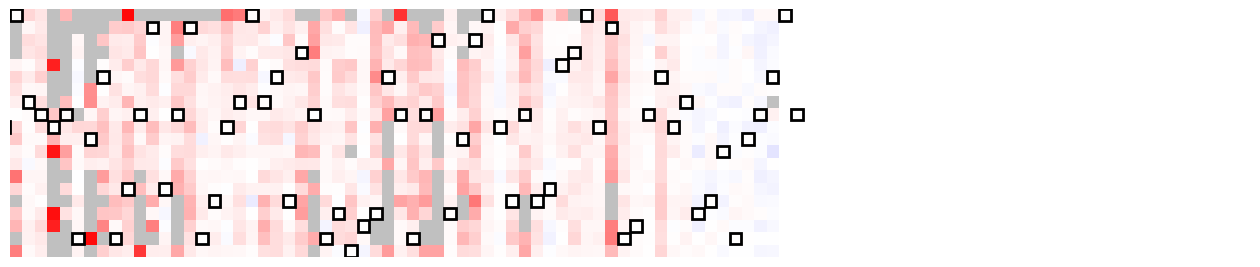

In [39]:
# Create supp file of heatmap at each position:

for k in [0,1,2,3,4]:
    fig, ax1 = plt.subplots(1, figsize=(16, 8), dpi=100)

    # Mask NaN values and assign them the 'nan_color'
    pivotBCs_masked = np.ma.masked_invalid(pivotVmax)
    cmapVmax.set_bad(nan_color)

    # Draw rectangles around WT values
    for i in np.arange(0,465):
        for j, AA in enumerate(INDEX_ORDER[::-1]):
            if AA == AMINOACID_SEQ[i+2]:
                rect = plt.Rectangle((i - 0.47, j - 0.47), 0.94,
                                     0.94, fill=False, edgecolor='black', lw = 2)
                ax1.add_patch(rect)

    ax1.imshow(pivotBCs_masked, cmap=cmapVmax)
    ax1.set_xlim((100*k - 0.5), (100*(k+1) - 0.49))
    ax1.set_ylim(-0.5, 19.5)
    ax1.axis('off')  # Turn off axis

    # Save the heatmap without ticks or labels
    plt.savefig(OUTPUT_FIGURE_PATH + 'Supp_Vmax_heatmap_040524_part' + str(k) + '_.png',
                format='png', bbox_inches='tight', pad_inches=0)

    plt.show()

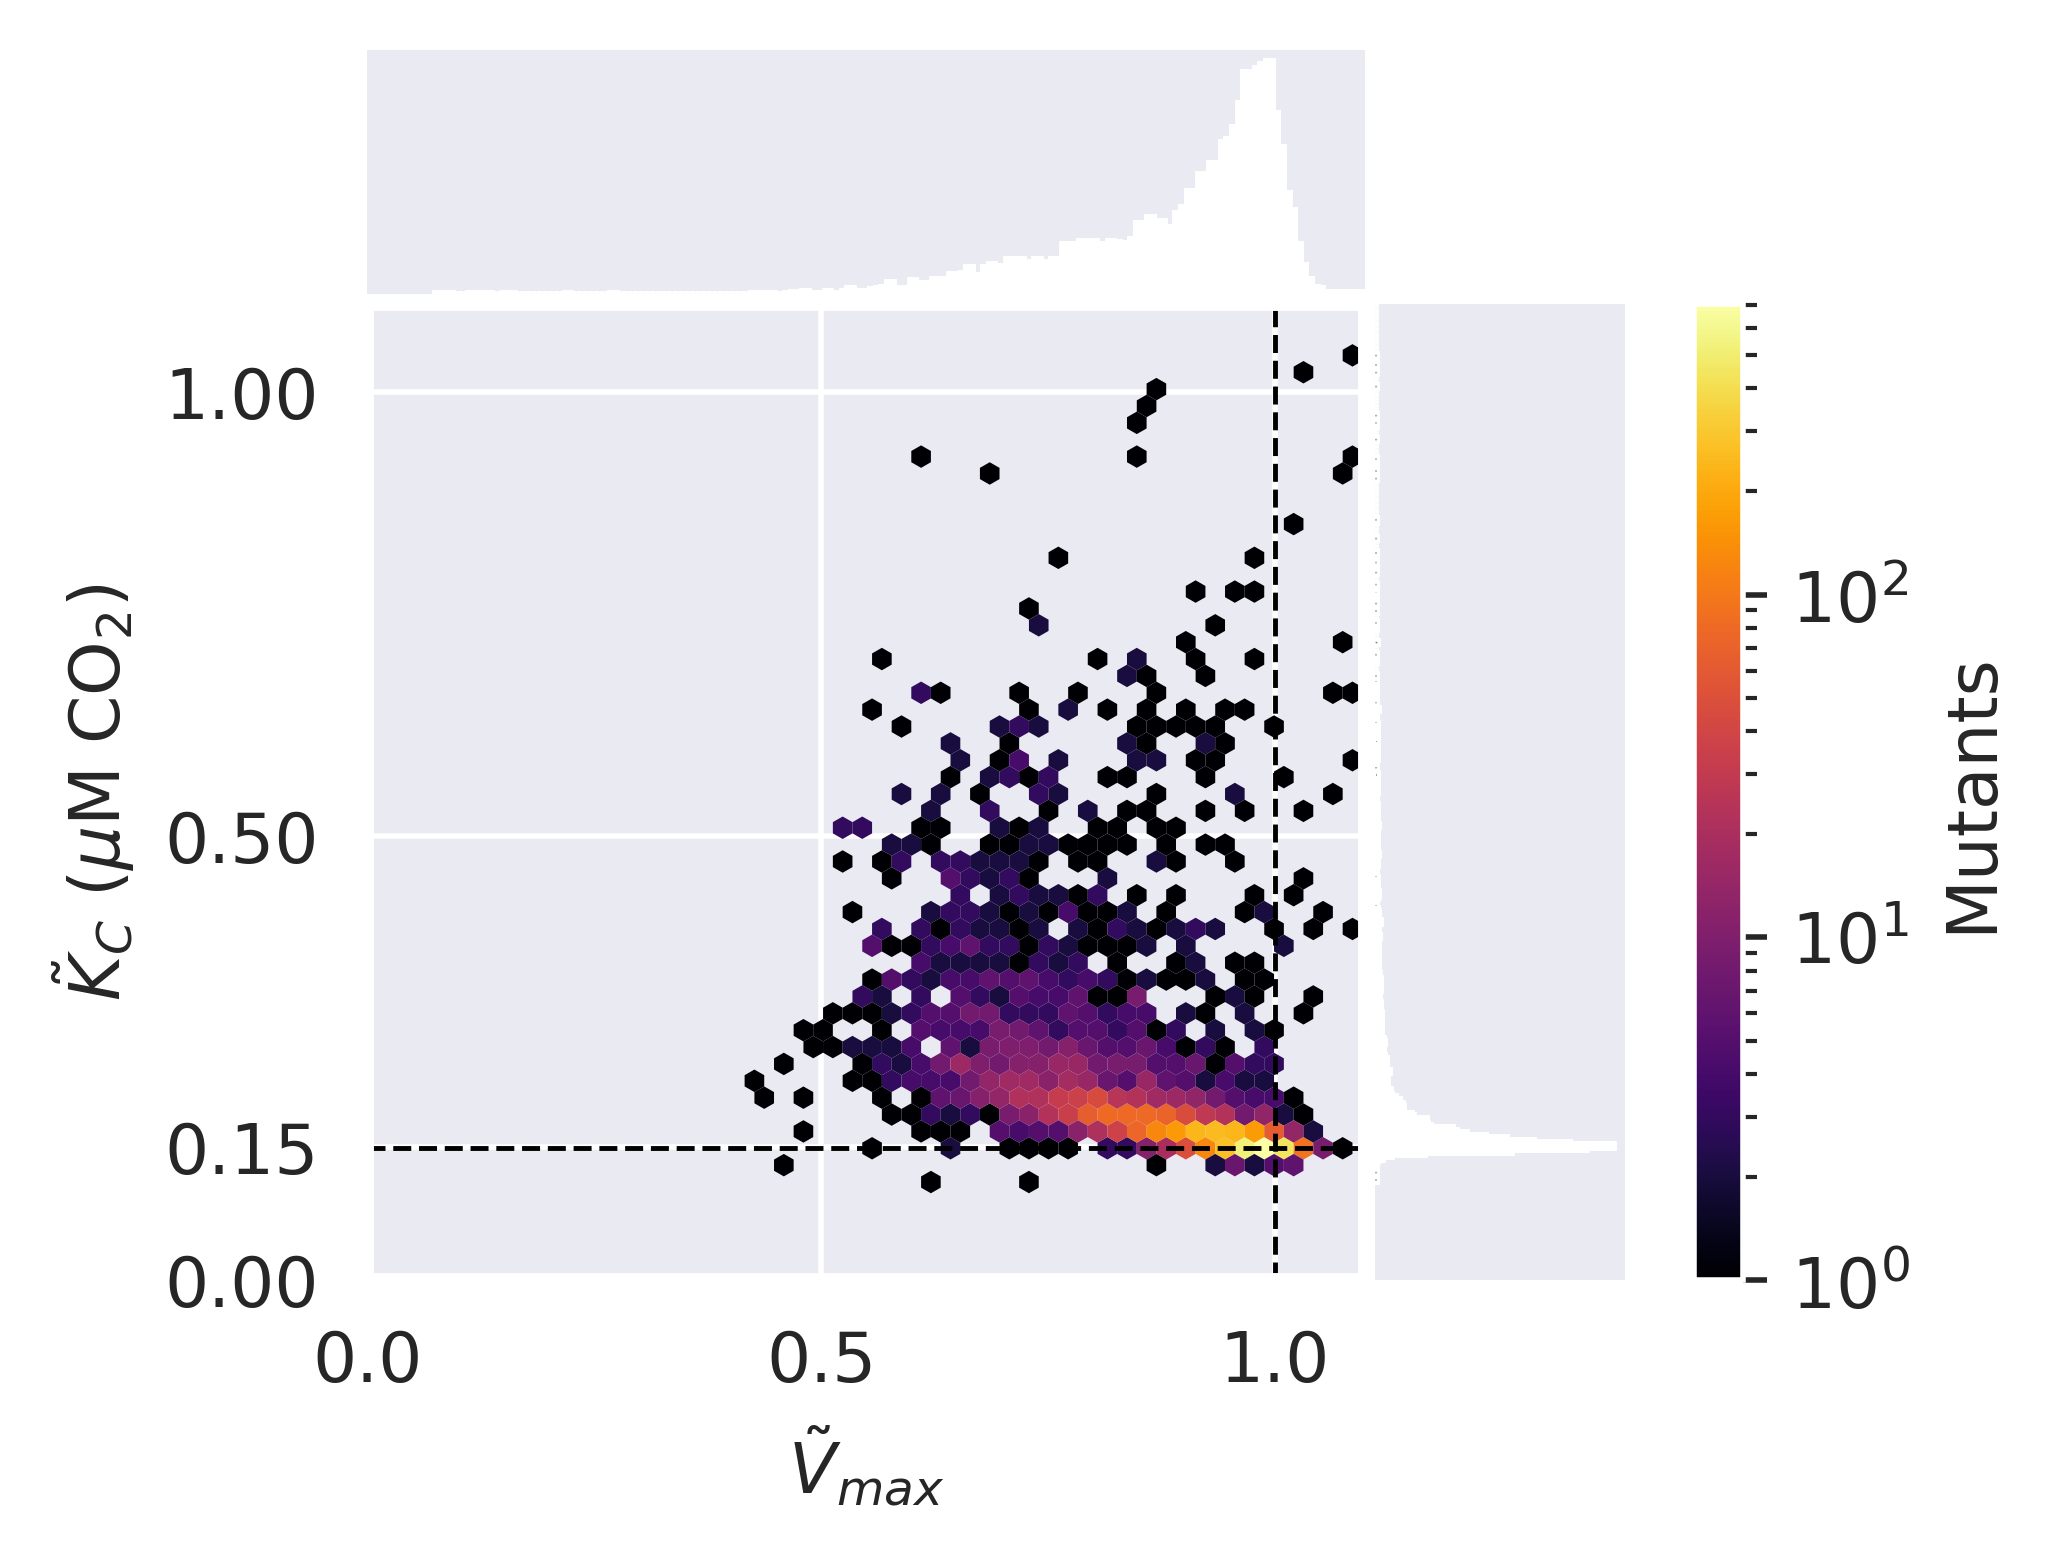

In [41]:
# Hexbin plot
plt.rcParams["figure.dpi"] = 500
cmap = 'inferno'

gridsize = 50

trimmed_error = pd.read_csv(TRIMMED_ERROR, index_col='mutant')

nextseq_enrichmend_dfForHexBin = nextseq_enrichmend_df[(nextseq_enrichmend_df['Vmax_median'] > 0) &
                              (nextseq_enrichmend_df['Vmax_median'] < 1.1) &
                            (nextseq_enrichmend_df['Km_median'] > 0) &
                            (nextseq_enrichmend_df['Km_median'] < 1.1)]

# Make hex figure
plt.figure()


hb0 = plt.hexbin(nextseq_enrichmend_dfForHexBin['Vmax_median'], nextseq_enrichmend_dfForHexBin['Km_median'],
                 mincnt=1, bins='log', cmap = cmap, gridsize = gridsize,
                )
hexcoords = hb0.get_offsets()
plt.draw()
fcs = hb0.get_facecolors()
plt.close()

difx_coords = hexcoords[1:,0] - hexcoords[:-1,0]
xmin = difx_coords[difx_coords > 1e-10].min()

dify_coords = hexcoords[1:,1] - hexcoords[:-1,1]
ymin = dify_coords[dify_coords > 1e-10].min()

ycorr_factor = xmin*np.sqrt(3) / ymin

circle_rad = xmin*np.sqrt(3)/3

xydata = nextseq_enrichmend_dfForHexBin[['Vmax_median', 'Km_median']].to_numpy()
xydata[:,1] = ycorr_factor * xydata[:,1]

hexcoords[:,1] = ycorr_factor * hexcoords[:,1]

xytree = sp.cKDTree(xydata)

# Loop over the points in B and query the k-d tree for neighbors within R
bin_indices = []
for hc in hexcoords:
    # Find the indices of points in A that are within R of b
    indices = xytree.query_ball_point(hc, circle_rad)
    # Append the indices to the output list
    bin_indices.append(indices)

bin_KmCOV_mean = []

for binind in bin_indices:
    bindat = nextseq_enrichmend_dfForHexBin.iloc[binind, :]
    bin_KmCOV_mean.append(bindat['Km_qbcov'].mean())

bin_KmCOV_mean = np.array(bin_KmCOV_mean)

maxCOV = 1
minCOV = 0.1

def alpha_transform(x0):
    if x0 <= minCOV:
        y0 = 1
    elif x0 > maxCOV:
        y0 = 0.1
        # This just omits the low ones
        y0 = 0
    else:
        y0 = (-0.9/(maxCOV-minCOV))*x0 + 1 + 0.1*(0.9/(maxCOV-minCOV))
        # Or just make anything with CoV<1 fully opaque
        y0 = 1
    return y0

v_alpha_transform = np.vectorize(alpha_transform, otypes='f')

KmCOV_alpha = v_alpha_transform(bin_KmCOV_mean)
fcs[:,-1] = KmCOV_alpha

fig = plt.figure(layout='constrained', figsize = (4,3))

# Create the main axes, leaving 25% of the figure space at the top and on the
# right to position marginals.
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
# The main axes' aspect can be fixed.
hb = ax.hexbin(nextseq_enrichmend_dfForHexBin['Vmax_median'],
               nextseq_enrichmend_dfForHexBin['Km_median'],
               mincnt=1,
               bins='log',
               cmap = cmap,
               linewidth = 0,
               gridsize = gridsize)

hb.set(array=None, facecolors=fcs)

# ax.scatter([1],[0.149], marker='+', color='black', s=50)
ax.axvline(1, linestyle = '--', color = 'black', linewidth = 0.7)
ax.axhline(0.149, linestyle = '--', color = 'black', linewidth = 0.7)

ax.set_xlabel('$\\tilde{V}_{max}$')
ax.set_ylabel('$\\tilde{K}_{C}$ ($\mu$M CO$_2$)')

ax_histx = ax.inset_axes([0, 1.01, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.01, 0, 0.25, 1], sharey=ax)

# Draw the scatter plot and marginals.
#scatter_hist(x, y, ax, ax_histx, ax_histy)

lowCoVData = nextseq_enrichmend_df[nextseq_enrichmend_df['Km_qbcov'] < 1]

ax_histx.hist(lowCoVData['Vmax_median'], bins=200, color='gray')
ax_histy.hist(lowCoVData['Km_median'], bins=500, orientation='horizontal', color='gray')

ax_histx.spines['top'].set_visible(False)
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['bottom'].set_visible(False)
ax_histx.spines['left'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['right'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)
ax_histy.spines['left'].set_visible(False)
ax_histx.xaxis.set_visible(False)
ax_histx.yaxis.set_visible(False)
ax_histy.xaxis.set_visible(False)
ax_histy.yaxis.set_visible(False)

# Make the plot frame thicker
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

ax.set_yticks([0, 0.15, 0.5, 1])

ax.set_xlim(0, 1.1)
ax.set_ylim(0, 1.1)

cbar = plt.colorbar(hb, ax=ax, label='Mutants')

fig.savefig(OUTPUT_FIGURE_PATH + 'hexbins_040524.svg', format='svg')


plt.show()


In [42]:
nextseq_enrichmend_df[(nextseq_enrichmend_df['Km_median'] < 0.135) & (nextseq_enrichmend_df['Km_qbcov'] < 1)][['mutant', 'Km_median', 'Km_qbcov']]

,mutant,Km_median,Km_qbcov
1879,A102Y,0.121362,0.202487
2149,G116Q,0.134477,0.093952
4994,V266T,0.132980,0.124803
5434,A289T,0.131075,0.436756
5436,A289C,0.112317,0.272141


In [43]:
fileS2 = nextseq_enrichmend_df[['mutant','position','WTresidue','residue','NP_11_66_13', 'NP_11_66_14', 'NP_11_66_15',
                                  'NP_11_66_16', 'NP_11_66_17', 'NP_11_66_18',
                                  'NP_11_66_37', 'NP_11_66_38', 'NP_11_66_39',
                   '5percent_CO2_20uM_IPTG',
                   'Km_median', 'Km_qbcov', 'Vmax_median', 'Vmax_qbcov']]
fileS2 = fileS2.rename(columns = {'NP_11_66_13':'rep1', 'NP_11_66_14':'rep2', 'NP_11_66_15':'rep3',
                                  'NP_11_66_16':'rep4', 'NP_11_66_17':'rep5', 'NP_11_66_18':'rep6',
                                  'NP_11_66_37':'rep7', 'NP_11_66_38':'rep8', 'NP_11_66_39':'rep9',
                                 '5percent_CO2_20uM_IPTG':'Fitness'})
fileS2 = fileS2.sort_values(by = 'position')
fileS2.to_csv('DataFileS2.csv')